In [1]:
from Validations import *
import pandas as pd
from ydata_profiling import ProfileReport

2024-02-13 22:05:34.335913: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 22:05:34.338298: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 22:05:34.364623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 22:05:34.364654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 22:05:34.365311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def fix_vlues(df, fill_strategy):
    """
    Fill null values in the DataFrame df based on a given fill strategy, considering sex and age.

    :param df: pandas DataFrame containing the dataset.
    :param fill_strategy: Dictionary specifying how to fill nulls for each column.
    """
    # Define age groups for segmentation
    age_bins = [0, 18, 30, 40, 50, 60, 70, 80, 120]  # Example age groups
    df['age_group'] = pd.cut(df['age'], bins=age_bins)

    for column, strategy in fill_strategy.items():
        # Apply different strategies based on the strategy type
        if strategy in ["mean", "median"]:
            for (sex, age_group), group_df in df.groupby(['sex', 'age_group']):
                if strategy == "mean":
                    value_to_fill = group_df[column].mean()
                elif strategy == "median":
                    value_to_fill = group_df[column].median()
                
                # Fill null values for the specific sex and age group
                df.loc[(df['sex'] == sex) & (df['age_group'] == age_group) & (df[column].isnull()), column] = value_to_fill

        elif strategy == "zero":
            df[column].fillna(0, inplace=True)
    
    # Clean up by removing the temporary 'age_group' column
    df.drop('age_group', axis=1, inplace=True)

def remove_negative_samples(df, column_name):
    """
    Removes samples from the DataFrame where the specified column has negative values, modifying the DataFrame in place.

    :param df: pandas DataFrame containing the dataset.
    :param column_name: String name of the column to check for negative values.
    """
    if column_name in df.columns:
        initial_count = df.shape[0]
        # Remove rows with negative values in the specified column in place
        df.drop(df[df[column_name] < 0].index, inplace=True)
        
        num_removed = initial_count - df.shape[0]
        if num_removed > 0:
            print(f"Removed {num_removed} samples with negative values in '{column_name}'.")
        else:
            print(f"No negative values found in '{column_name}'.")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")

def remove_samples_below_threshold(df, column_name, threshold):
    """
    Removes samples from the DataFrame where the value in the specified column is lower than the given threshold,
    modifying the DataFrame in place.

    :param df: pandas DataFrame containing the dataset.
    :param column_name: String name of the column to check values in.
    :param threshold: Numeric value representing the threshold below which samples will be removed.
    """
    if column_name in df.columns:
        initial_count = df.shape[0]
        # Remove rows with values below the threshold in the specified column in place
        df.drop(df[df[column_name] < threshold].index, inplace=True)
        
        num_removed = initial_count - df.shape[0]
        if num_removed > 0:
            print(f"Removed {num_removed} samples with values in '{column_name}' below {threshold}.")
        else:
            print(f"No samples with values in '{column_name}' below {threshold} found.")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")

def remove_outliers(df, column, method="IQR"):
    """
    Remove or cap outliers in a specified column based on the IQR method or a defined cap.

    :param df: pandas DataFrame containing the dataset.
    :param column: Column to check for outliers.
    :param method: Method to use for outlier detection ('IQR' for Interquartile Range).
    :param cap: Optional tuple (min, max) to cap values.
    """
    if method == "IQR":
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower_bound, upper_bound)


def remove_feature(df, column_name):
    """
    Remove a specified feature (column) from the DataFrame if it exists.

    :param df: pandas DataFrame from which to remove the column.
    :param column_name: String name of the column to be removed.
    """
    if column_name in df.columns:
        df.drop(column_name, axis=1, inplace=True)
        print(f"Column '{column_name}' has been removed.")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")

def convert_feature_to_values(df, column_name, value_map):
    """
    Convert a feature with boolean or categorical options into numerical values based on a provided mapping.

    :param df: pandas DataFrame containing the dataset.
    :param column_name: String name of the column to convert.
    :param value_map: Dictionary defining the mapping from categories or boolean values to numerical values.
    """
    if column_name in df.columns:
        # Check if column is boolean, object, or category
        if df[column_name].dtype == 'bool' or df[column_name].dtype == 'object' or df[column_name].dtype == 'category':
            # Apply mapping for boolean, object, or category types
            df[column_name] = df[column_name].map(value_map)
            print(f"Column '{column_name}' has been converted based on the provided mapping.")
        else:
            print(f"Column '{column_name}' is not of a type that requires conversion (bool, object, or category).")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")

In [3]:
df = pd.read_csv('data/salary-dataset.csv')
df.sample(10)

,id,age,name,last_name,sex,married,income,childrens,weight,height
993,994,69,Tammy,Hayes,Male,No,28886.983042,3.0,88.708987,172.921253
189,190,75,David,Schultz,Male,Yes,57025.737483,1.0,80.773696,169.307929
654,655,18,Linda,Galvan,Female,Yes,38178.836601,2.0,75.826462,178.224706
365,366,41,Todd,Martinez,Female,Yes,-23931.833786,2.0,60.186057,144.180496
769,770,78,Kenneth,Moore,Female,No,52963.696055,0.0,81.249842,156.176557
792,793,29,Jill,Harmon,Male,Yes,22071.174586,1.0,77.022301,177.472540
116,117,37,Lisa,Garcia,Female,No,62659.800052,3.0,60.421377,145.790545
98,99,42,Catherine,Sanchez,Male,Yes,50887.937480,NaN,67.160591,164.630106
846,847,58,Thomas,Johnson,Male,No,34130.517516,1.0,14.162761,169.848396
790,791,35,Justin,Moran,Female,Yes,32916.495846,1.0,68.328547,142.025226


## Removing outliers
Outliers are data points that significantly differ from other observations. They can skew the results of data analysis and lead to misleading conclusions because they may indicate variability in the data, experimental errors, or a novelty not accounted for by the model. In machine learning, they can affect the training process, resulting in a model that doesn’t perform well with the typical data it encounters.

Again, there are many way to handle outliers, this our case we will use remove low/negative values and IQR. </br>
The IQR method uses the middle 50% range of data to create a “normal zone” and flags any points outside this zone as outliers. It's like drawing lines in the sand; anything outside those lines is considered unusual.</br>

There should be two feature that has outlier data.</br>
Your task:</br>
Fill in the colunms and run the functions.</br>

<details>
    <summary>Hint</summary>
    <p>
         One of the feature shouldn't have negative values, and the other shouldn't have such low values.
     </p>
</details>

<details>
    <summary>Solution</summary>
    <p>
        remove_negative_samples(df, 'income')</br>
        remove_samples_below_threshold(df,'weight',20)</br>
        remove_outliers(df, 'income', method="IQR")</br>
        remove_outliers(df, 'weight', method="IQR")</br>
     </p>
</details>

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


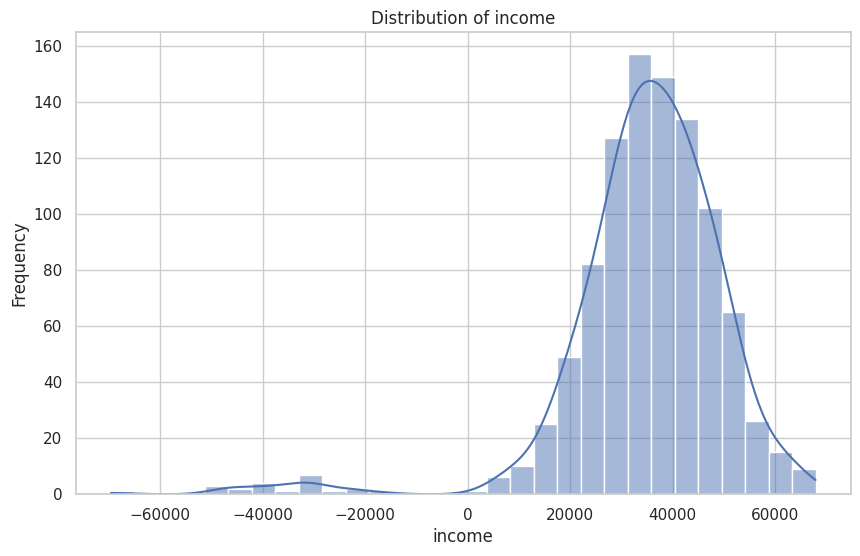

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


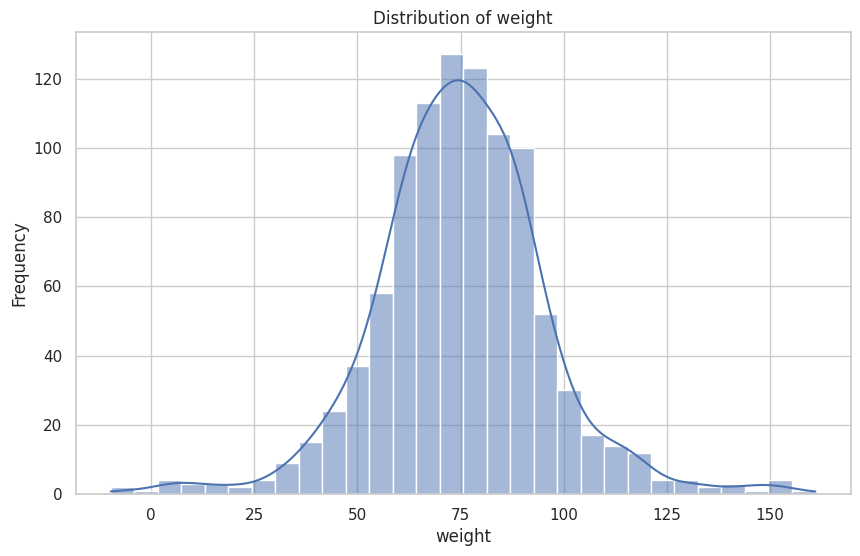

In [4]:
plot_feature_distribution(df, 'income')
plot_feature_distribution(df, 'weight')

In [5]:
remove_negative_samples(df, 'income')
remove_samples_below_threshold(df,'weight',20)
remove_outliers(df, 'income', method="IQR")
remove_outliers(df, 'weight', method="IQR")

Removed 22 samples with negative values in 'income'.
Removed 11 samples with values in 'weight' below 20.


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


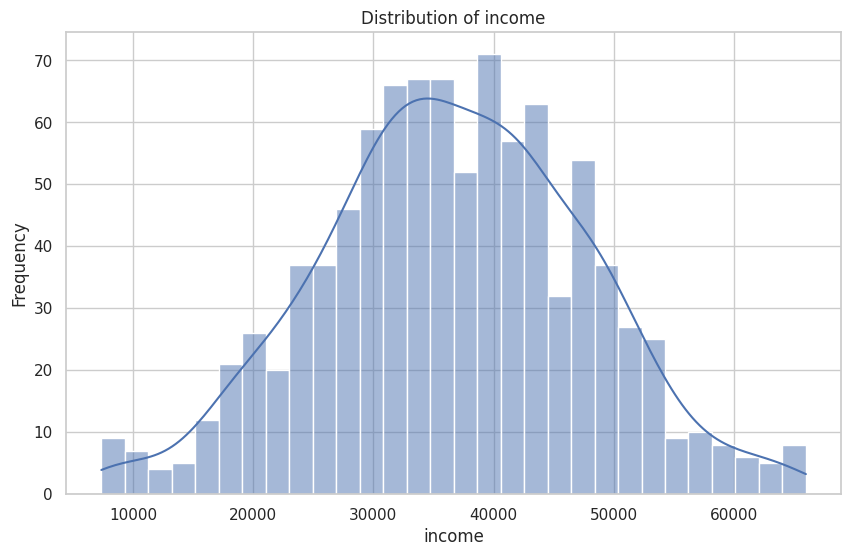

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


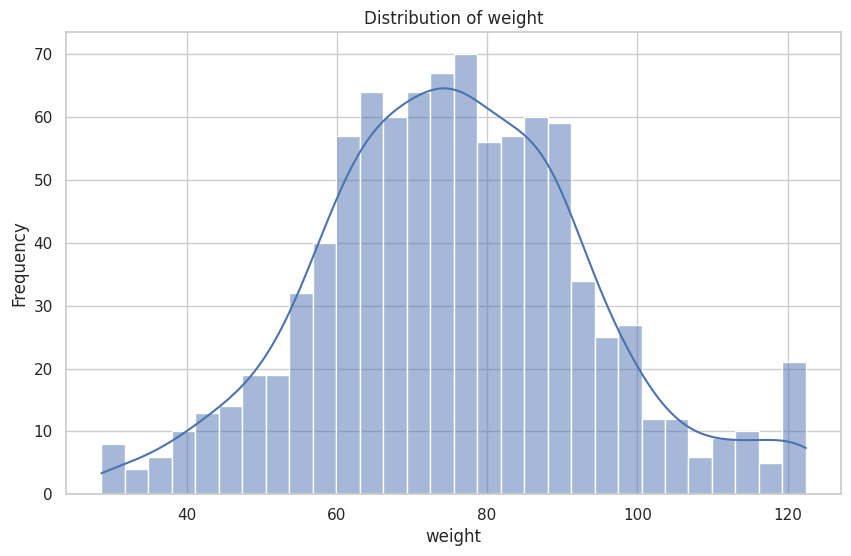

In [6]:
plot_feature_distribution(df, 'income')
plot_feature_distribution(df, 'weight')

## Fix features with null

Null values in data can be problematic because they represent missing, unknown, or unrecorded information, which can lead to inaccurate analyses, biased results, and ultimately poor decision-making. They can also disrupt the performance of many machine learning algorithms, which require complete data sets to function correctly. </br></br>
Should be 4 features with null that need to be fixed - to fix we need to find the features and pick for each one of them how to handle and missing data.</br>
There are many ways to handle null values, in our case, because we have null value on numerical fileds, we will use math to fill in.

The strategies:
1. mean - put in the mean value of the feature based on sex and age.
2. meadian - put in the median value of the feature based on sex and age.
3. zero - put zero as the value.</br>

Your task:</br>
Add to the "fill_strategy" map the name of the features with null values as key, and the strategy as value.</br>
fill_strategy = {'feature_name':'strategy',...} </br>
<details>
    <summary>Hint</summary>
    <p>
        Should think of what is more reasanable and logical to put based on the feature!</br>
        You can't have 1.2 kids right?
     </p>
</details>

<details>
    <summary>Solution</summary>
    <p>
        fill_strategy = {'income': 'mean', "childrens":'median', "weight":'mean', "height":'mean'}
     </p>
</details>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 967 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         967 non-null    int64  
 1   age        967 non-null    int64  
 2   name       967 non-null    object 
 3   last_name  967 non-null    object 
 4   sex        967 non-null    object 
 5   married    967 non-null    object 
 6   income     947 non-null    float64
 7   childrens  907 non-null    float64
 8   weight     940 non-null    float64
 9   height     925 non-null    float64
dtypes: float64(4), int64(2), object(4)
memory usage: 83.1+ KB


In [8]:
fill_strategy = {'income': 'mean', "childrens":'median', "weight":'mean', "height":'mean'}
fix_vlues(df, fill_strategy)
check_nulls_and_info(df)

No null values found in the DataFrame.
<class 'pandas.core.frame.DataFrame'>
Index: 967 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         967 non-null    int64  
 1   age        967 non-null    int64  
 2   name       967 non-null    object 
 3   last_name  967 non-null    object 
 4   sex        967 non-null    object 
 5   married    967 non-null    object 
 6   income     967 non-null    float64
 7   childrens  967 non-null    float64
 8   weight     967 non-null    float64
 9   height     967 non-null    float64
dtypes: float64(4), int64(2), object(4)
memory usage: 83.1+ KB


/tmp/ipykernel_4426/246540078.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (sex, age_group), group_df in df.groupby(['sex', 'age_group']):
/tmp/ipykernel_4426/246540078.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (sex, age_group), group_df in df.groupby(['sex', 'age_group']):
/tmp/ipykernel_4426/246540078.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (sex, age_group), group_df in df.gr

## Feature selection
Removing features, also known as feature selection, can improve a model's performance by eliminating irrelevant or redundant data, reducing overfitting, and making the model simpler and faster to run.

Should be 3 features that are irrelevant for our goal.
Your task:</br>
Fill in the colunms and run the functions.</br>

<details>
    <summary>Hint</summary>
    <p>
         They are features that will not help us with the task, think if someone asked you "guess my salary!" what information is useless from the feature.
     </p>
</details>

<details>
    <summary>Solution</summary>
    <p>
        remove_feature(df, 'name')</br>
        remove_feature(df, 'last_name')</br>
        remove_feature(df, 'id')</br>
     </p>
</details>


In [10]:
remove_feature(df, 'name')
remove_feature(df, 'last_name')
remove_feature(df, 'id')
df.info()

Column 'name' has been removed.
Column 'last_name' has been removed.
Column 'id' has been removed.
<class 'pandas.core.frame.DataFrame'>
Index: 967 entries, 0 to 999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        967 non-null    int64  
 1   sex        967 non-null    object 
 2   married    967 non-null    object 
 3   income     967 non-null    float64
 4   childrens  967 non-null    float64
 5   weight     967 non-null    float64
 6   height     967 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 60.4+ KB


In [ ]:
convert_feature_to_values(df, column_name, value_map):